In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import json
from datetime import datetime,timedelta
from collections import Counter
from functools import partial
import copy
import scipy.stats
import random
from torch import sort
import seaborn as sns
from py2neo import Graph
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
import os
pd.set_option("display.max_columns",50)
%matplotlib inline

In [2]:
def riqi_ftime(df):
    df.insert(1,'riqi',df.ftime.map(lambda x: x.split(' ')[0]))
    df.insert(2,'fftime',df.ftime.map(lambda x: x.split(' ')[1]))
    df.drop('ftime',axis=1,inplace=True)
    df.fftime=df.fftime.map(lambda x: x.split(':')[0]+':'+x.split(':')[1])
    df.fftime=df.fftime.map(lambda x: timesplit(x))
    return df

def timesplit(input:str,sep=':',gra="15"):
    h,m=input.split(sep)
    m=int(m)
    if gra=="10":
        if m<10:
            m_str='00'
        elif m<20:
            m_str='10'
        elif m<30:
            m_str='20'
        elif m<40:
            m_str='30'
        elif m<50:
            m_str='40'
        else:
            m_str='50'
    elif gra=="15":
        if m<15:
            m_str='00'
        elif m<30:
            m_str='15'
        elif m<45:
            m_str='30'
        else:
            m_str='45'
    return h+':'+m_str

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p,M)+0.5*scipy.stats.entropy(q, M)


## Data preparation and processing

In [3]:
trip_df_generate_raw = pd.read_csv("./data/generate_tq_path_tt.csv",encoding='utf-8') # the generated data
trip_df_history_raw = pd.read_csv("./data/raw_tq.csv",encoding='utf-8') # the original data
trip_df_history_raw = trip_df_history_raw.drop('riqi',axis =1)
trip_df_history=riqi_ftime(trip_df_history_raw)
trip_df_generate = riqi_ftime(trip_df_generate_raw)

In [4]:
# one week (2019-08-12 to 2019-08-18) 
trip_df_g = trip_df_generate.query("'2019-08-12'<=riqi<='2019-08-18'") 
trip_df_h = trip_df_history.query("'2019-08-12'<=riqi<='2019-08-18'")
trip_df_h.columns = ['hphm','riqi','fftime','fpark','tpark','path','route','traveltime'] 
## split data by weekday and holiday; weekday: 12-16，holiday: 17-18
# trip_df_g = trip_df_generate.query("riqi=='2019-08-17' or riqi == '2019-08-18'")
# trip_df_h = trip_df_history.query("riqi=='2019-08-17' or riqi == '2019-08-18'")
# trip_df_h.columns = ['hphm','riqi','fftime','fpark','tpark','path','route','traveltime'] 
## further distinguishing time periods (fine-grained)
# trip_df_g = trip_df_generate.query("'17:00'<=fftime<='18:30'") 
# trip_df_h = trip_df_history.query("'17:00'<=fftime<='18:30'")

In [6]:
trip_df_h

,hphm,riqi,fftime,fpark,tpark,path,route,traveltime
0,鲁R3093998,2019-08-14,17:45,P344,P389,30023-30023,9040-9041-9040,6.00
1,鲁R3093998,2019-08-16,06:30,P389,P134,30023-30069-8788-30068-30067-30171-30170-30032...,9040-9041-8461-9079-9078-9077-9147-9051-9053-9...,31.11
2,鲁R3093998,2019-08-16,08:00,P196,P389,30040-30040-30122-30098-30173-30172-30032-3017...,9063-9062-9063-9102-9103-9148-9053-9051-9147-9...,29.74
3,鲁R3093998,2019-08-16,08:45,P389,P134,30023-30069-8788-30068-30067-30171-30170-30032...,9040-9041-8461-9079-9078-9077-9147-9051-9053-9...,28.45
4,鲁R3093998,2019-08-16,10:00,P196,P389,30040-30040-30122-30098-30173-30172-30032-3017...,9063-9062-9063-9102-9103-9148-9053-9051-9147-9...,26.45
...,...,...,...,...,...,...,...,...
213264,鄂J3589933,2019-08-12,11:45,P111,P111,30182-30181,9155-9156-5100,6.00
213265,鄂J3589933,2019-08-12,13:45,P111,P111,30182-1210,9156-9155-5190,3.52
213266,鄂J3589933,2019-08-12,18:30,P111,P111,30182-30181,9155-9156-5100,6.00
213267,鄂J3589933,2019-08-13,07:15,P111,P46,30182-1210,9156-9155-5190,6.00


## Aggregated level validation-temporal

In [9]:
t_zhen=dict(Counter(trip_df_h.fftime))
t_zhen_g=dict(Counter(trip_df_g.fftime))
t_zhen=sorted(t_zhen.items(),key=lambda x:x[0])
t_zhen_g=sorted(t_zhen_g.items(),key=lambda x:x[0])
x=[(datetime.strptime(i[0],"%H:%M")-datetime(1900,1,1,0,0)).seconds/60 for i in t_zhen]
x=np.asarray(x)
y=np.asarray([i[1] for i in t_zhen])
y_g=np.asarray([i[1] for i in t_zhen_g])

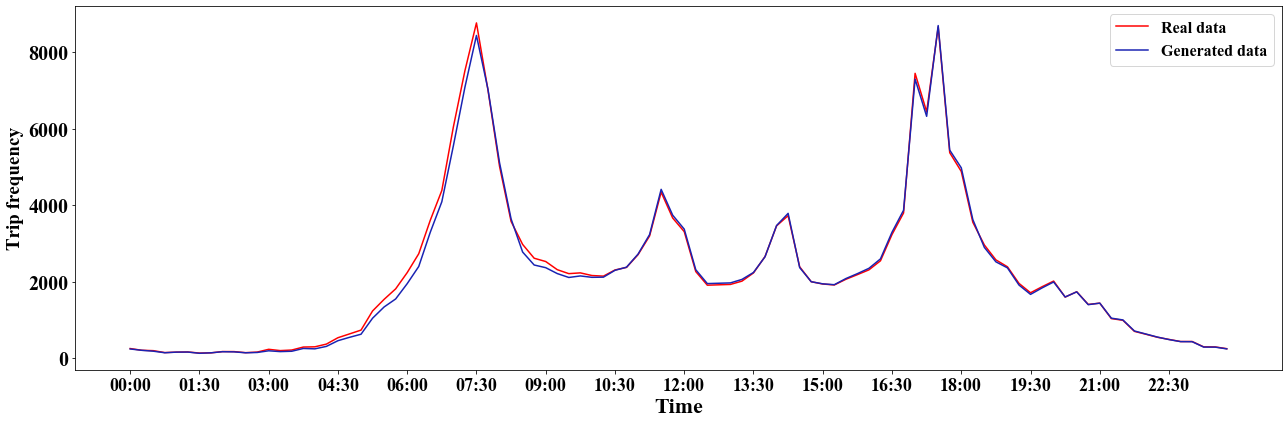

In [10]:
fig1,ax1=plt.subplots(1,1,figsize=(18,6))
x_tick=list(set(trip_df_h.fftime))
x_tick=sorted(x_tick)[::6]
ax1.plot([i[0] for i in t_zhen],[i[1] for i in t_zhen],label='Real data',color='r')
ax1.plot([i[0] for i in t_zhen],[i[1] for i in t_zhen_g],label='Generated data',color='#1923b3')
ax1.set_ylabel('Trip frequency', fontproperties='Times New Roman',size=19)
ax1.set_xlabel('Time',fontproperties='Times New Roman',size=22)
plt.legend(prop={'family' : 'Times New Roman',"size":16})
plt.xticks(x_tick,fontproperties='Times New Roman', size=18)
plt.yticks(fontproperties='Times New Roman', size=20)
plt.tight_layout()
# plt.savefig('./fig/passby_holiday.pdf')

### Calculate JS dispersion

In [11]:
print(JS_divergence(y,y_g))

0.00024403701639192743


## Aggregated level validation-spatial

### Hotness of traffic zone with Top-k

In [12]:
OD_park_k = 50 # set "k" of top-k
# trip destination traffic zone counting of the real data
real_tpark = Counter(trip_df_h.tpark)
real_ftpark  = sorted(real_tpark.items(),key=lambda x:x[1],reverse=True)
print('the number of traffic zones:',len(real_ftpark))
top_real_ftpark = [i[0] for i in real_ftpark[:OD_park_k]] 
# trip destination traffic zone counting of the generated data
generate_tpark = Counter(trip_df_g.tpark)
generate_ftpark  = sorted(generate_tpark.items(),key=lambda x:x[1],reverse=True)
top_generate_ftpark = [i[0] for i in generate_ftpark[:OD_park_k]] 
print('overlap number:',len(set(top_generate_ftpark)&set(top_real_ftpark)))
print('overlap ratio:',len(set(top_generate_ftpark)&set(top_real_ftpark))/OD_park_k)

the number of traffic zones: 207
overlap number: 47
overlap ratio: 0.94


### trip origin and destination with Top-k

In [13]:
trip_df_h.insert(4,'od',trip_df_h.fpark+'-'+trip_df_h.tpark)
trip_df_g.insert(4,'od',trip_df_g.fpark+'-'+trip_df_g.tpark)

In [14]:
OD_pair_k = 143 # # set "k" of top-k
real_od=Counter(trip_df_h.od)
real_od = sorted(real_od.items(),key=lambda x:x[1],reverse=True)
print('the number of ODs:',len(real_od))
generate_od = Counter(trip_df_g.od)
generate_od = sorted(generate_od.items(),key=lambda x:x[1],reverse=True)
top_real_od = [i[0] for i in real_od[:OD_pair_k]]
top_generate_od = [i[0] for i in generate_od[:OD_pair_k]]
print('overlap number:',len(set(top_generate_od)&set(top_real_od)))
print('overlap ratio:', len(set(top_generate_od)&set(top_real_od))/OD_pair_k)


the number of ODs: 15699
overlap number: 102
overlap ratio: 0.7132867132867133


### Distribution of road access frequency

In [15]:
trip_df_g.loc[:,'path']=trip_df_g.path.map(lambda x:x.split('-'))
trip_df_h.loc[:,'path']=trip_df_h.path.map(lambda x:x.split('-'))

c:\Users\LiGuilong\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
trip_df_h    

,hphm,riqi,fftime,fpark,od,tpark,path,route,traveltime
0,鲁R3093998,2019-08-14,17:45,P344,P344-P389,P389,"[30023, 30023]",9040-9041-9040,6.00
1,鲁R3093998,2019-08-16,06:30,P389,P389-P134,P134,"[30023, 30069, 8788, 30068, 30067, 30171, 3017...",9040-9041-8461-9079-9078-9077-9147-9051-9053-9...,31.11
2,鲁R3093998,2019-08-16,08:00,P196,P196-P389,P389,"[30040, 30040, 30122, 30098, 30173, 30172, 300...",9063-9062-9063-9102-9103-9148-9053-9051-9147-9...,29.74
3,鲁R3093998,2019-08-16,08:45,P389,P389-P134,P134,"[30023, 30069, 8788, 30068, 30067, 30171, 3017...",9040-9041-8461-9079-9078-9077-9147-9051-9053-9...,28.45
4,鲁R3093998,2019-08-16,10:00,P196,P196-P389,P389,"[30040, 30040, 30122, 30098, 30173, 30172, 300...",9063-9062-9063-9102-9103-9148-9053-9051-9147-9...,26.45
...,...,...,...,...,...,...,...,...,...
213264,鄂J3589933,2019-08-12,11:45,P111,P111-P111,P111,"[30182, 30181]",9155-9156-5100,6.00
213265,鄂J3589933,2019-08-12,13:45,P111,P111-P111,P111,"[30182, 1210]",9156-9155-5190,3.52
213266,鄂J3589933,2019-08-12,18:30,P111,P111-P111,P111,"[30182, 30181]",9155-9156-5100,6.00
213267,鄂J3589933,2019-08-13,07:15,P111,P111-P46,P46,"[30182, 1210]",9156-9155-5190,6.00


In [95]:
trip_df_g

,hphm,riqi,fftime,fpark,od,tpark,path,traveltime
0,皖P3133933,2019-08-12,13:30,P72,P72-P123,P123,"[1127, 1041, 1040, 1034, 1042, 1216, 1217, 105...",27.71
1,皖P3133933,2019-08-12,14:00,P123,P123-P176,P176,"[1056, 1025, 8008, 21203, 21225, 21208, 21231,...",29.68
2,皖P3133933,2019-08-12,15:15,P160,P160-P105,P105,"[1040, 1041, 1015]",5.80
3,皖P3133933,2019-08-12,17:45,P105,P105-P162,P162,"[1015, 1037]",6.00
4,皖P3133933,2019-08-12,18:15,P162,P162-P96,P96,"[1043, 1040, 1034, 8005, 8004, 1053]",10.05
...,...,...,...,...,...,...,...,...
1064473,皖P2267123,2019-08-15,10:00,P344,P344-P46,P46,"[30024, 30062, 21245, 15363, 1130, 1216, 1217,...",24.22
1064474,皖P2267123,2019-08-17,19:45,P46,P46-P64,P64,"[21143, 8523, 21144, 1206, 1234, 8510, 1230, 1...",16.40
1064475,皖P2009151,2019-08-12,07:00,P154,P154-P2,P2,"[1048, 1131, 1130, 15342, 21214, 21231, 21231,...",14.66
1064476,皖P2009151,2019-08-14,10:00,P2,P2-P154,P154,"[21216, 21215, 21242, 21242, 21214, 15342, 113...",10.17


In [17]:
flow_list = []
flow_list_g = []
for row in trip_df_h.path:
    flow_list.extend(row)
counter_flow=Counter(flow_list)
dict_flow = dict(counter_flow)
sorted_flow = sorted(dict_flow.items(),key=lambda x:x[1],reverse=True)
top_flow=sorted_flow[:100]
top_flow_dict=dict(top_flow)

for row in trip_df_g.path:
    flow_list_g.extend(row)
counter_flow_g=Counter(flow_list_g)
dict_flow_g = dict(counter_flow_g)
top_flow_g_dict = {k:dict_flow_g[k] for k in top_flow_dict}

In [97]:
len(sorted_flow)

448

In [18]:
x_ticks_flow = top_flow_dict.keys()
y_flow = np.asarray(list(top_flow_dict.values()))
y_flow = y_flow/sum(y_flow)
y_flow_g = np.asarray(list(top_flow_g_dict.values()))
y_flow_g = y_flow_g/sum(y_flow_g)

[-0.02, -0.015, -0.01, -0.005, 0.0, 0.005, 0.01, 0.015, 0.02, 0.025]


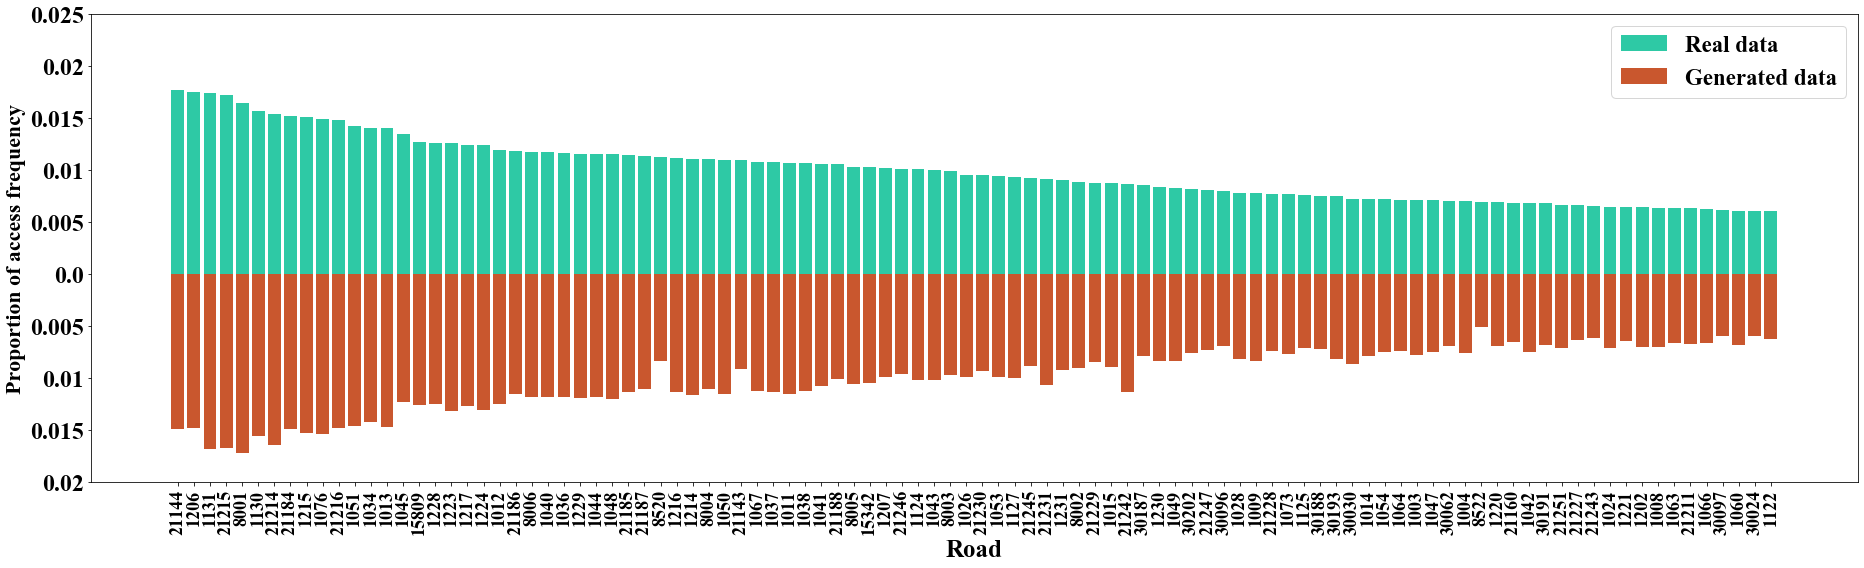

In [19]:
fig_flow,ax_flow = plt.subplots(1,1,figsize=(26,8))
ax_flow.bar(x_ticks_flow,y_flow,label='Real data',color ='#2ec9a5')
ax_flow.bar(x_ticks_flow,-y_flow_g,label='Generated data',color = '#c9572e')
plt.legend(prop={'family' : 'Times New Roman',"size":23})
plt.xticks(rotation=90)

plt.ylim([-0.02,0.025])
# plt.ylim([-0.04,0.04])
y_flow_ticks = list(ax_flow.get_yticks())
y_flow_ticks = [round(i,3) for i in y_flow_ticks]
plt.yticks(ax_flow.get_yticks(),np.array([abs(i) for i in y_flow_ticks]))
ax_flow.set_ylabel('Proportion of access frequency', fontproperties='Times New Roman',size=22)
ax_flow.set_xlabel('Road',fontproperties='Times New Roman',size=25)
plt.xticks(fontproperties='Times New Roman', size=18)
plt.yticks(fontproperties='Times New Roman', size=24)
# plt.xlim([-0.0025,0.0025])
print(y_flow_ticks)
plt.tight_layout()
# plt.savefig('./fig/flow_pro_sj.pdf')
plt.show()


In [140]:
print(JS_divergence(y_flow,y_flow_g))

0.0015597392402024578


### Trip spatial continuity test

In [127]:
def trip_continuity_test(input_df:pd.DataFrame):
    max_num = len(input_df)
    tol_count = 0
    continuous = 0
    input_df = input_df.sort_values(by=['hphm','riqi','fftime'], ascending=(False, True, True))  
    input_df.reset_index(drop=True, inplace=True)
    for index,row in input_df.iterrows():
        if index == max_num - 1:
            break
        if row['hphm'] == input_df.iloc[index + 1, 0]:
            tol_count += 1
            fpark = input_df.iloc[index + 1].fpark
            tpark = row.tpark
            if fpark == tpark:
                continuous+=1
            if index%1000 == 0:
                print('tol:', tol_count/max_num,'con:',continuous/tol_count)
            
trip_continuity_test(trip_df_g)

tol: 4.528185691838851e-06 con: 0.0
tol: 0.0014535476070802712 con: 0.40809968847352024
tol: 0.007005103265274703 con: 0.3749191984486102
tol: 0.008698644714022433 con: 0.3862571577303488
tol: 0.016541462332287322 con: 0.4054202025732275
tol: 0.03378932163250151 con: 0.38367729831144465
tol: 0.04283210845910369 con: 0.384395813510942
tol: 0.045141483161941505 con: 0.3856956565352593
tol: 0.049443259569188415 con: 0.3822694385932778
tol: 0.05585517050883223 con: 0.38378597486826105
tol: 0.05812379154044349 con: 0.38617949516983485
tol: 0.06040599712913027 con: 0.38808095952023985
tol: 0.06263386448951498 con: 0.3884470792365529
tol: 0.07158155941658856 con: 0.3910045546558704
tol: 0.084944235393205 con: 0.3944240098086252
tol: 0.08726719465311833 con: 0.3954441677044417
tol: 0.08959921028441534 con: 0.3958154343761055
tol: 0.09181349308772455 con: 0.3974156638390215
tol: 0.10077930075756547 con: 0.4011053199137311
tol: 0.10953228369988996 con: 0.4039026003555335
tol: 0.11286050018339153

## Individual-level validation

In [21]:
def judge_week_time_slot(time):  
        time_morpeak_start = "06:30"
        time_morpeak_end = "08:30"
        time_ant_end = "13:30"
        time_noon_end = "14:30"
        time_even_peak_start = "17:00"
        time_even_peak_end = "18:30"
        time_even_ping = "22:30"
        if time >= time_morpeak_start and time < time_morpeak_end:
            shiduan = "Morning_peak" 
        elif time >= time_morpeak_end and time < time_ant_end:
            shiduan = "Morning_flat"
        elif time >= time_ant_end and time < time_noon_end:
            shiduan = "Noon_peak"
        elif time >= time_noon_end and time < time_even_peak_start:
            shiduan = "Noon_flat"
        elif time >= time_even_peak_start and time < time_even_peak_end:
            shiduan = "Evening_peak"
        elif time >= time_even_peak_end and time < time_even_ping:
            shiduan = "Evening_flat"
        else:
            shiduan = "Night"
        return shiduan 

def make_json_f_sd( in_df:pd.DataFrame):
    tol_dict = {'veh':[],"sd":[]}
    v_list = list(set(in_df.hphm))
    for i in v_list:
        sub_df = in_df.query(f"hphm == '{i}'")
        sub_list = list(set(sub_df.fftime))
        tol_dict['veh'].append(i)
        tol_dict['sd'].append(len(sub_list))
    return tol_dict    

def sd_combining_forplot(in_list:list):
    dic_in = dict(Counter(in_list))
    sum_val = sum(dic_in.values())
    dic_in = {k:v/sum_val for k,v in dic_in.items()}
    dic_in = {i:round(dic_in[i],3) if i in dic_in else 0 for i in range(1,8)}
    return dic_in
    
    
    

### Distribution of the number of trip time slots

In [22]:
# the gnerated data
trip_df_g_f_sd = trip_df_g 
trip_df_g_f_sd.fftime = trip_df_g.fftime.map(lambda x: judge_week_time_slot(x))
# the real data
trip_df_h_f_sd = trip_df_h 
trip_df_h_f_sd.fftime = trip_df_h.fftime.map(lambda x: judge_week_time_slot(x))

c:\Users\LiGuilong\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
trip_df_g_f_sd

,hphm,riqi,fftime,fpark,od,tpark,path,traveltime
0,皖P2350384,2019-08-12,Noon_flat,P122,P122-P165,P165,"[30097, 30096, 30101, 30106, 30103, 30028, 300...",18.41
1,皖P2350384,2019-08-13,Night,P165,P165-P122,P122,"[8008, 1025, 1026, 1054, 1053, 8004, 8005, 800...",27.36
2,皖P2350384,2019-08-13,Noon_flat,P122,P122-P165,P165,"[30097, 30096, 30101, 30112, 30104, 30028, 300...",16.38
3,皖P2350384,2019-08-13,Evening_flat,P165,P165-P119,P119,"[21220, 8009, 1047, 8008, 8008, 1214, 21207]",9.23
4,皖P2350384,2019-08-14,Night,P119,P119-P122,P122,"[1215, 1214, 1047, 1220, 1222, 1221, 21184, 21...",25.95
...,...,...,...,...,...,...,...,...
211317,皖A2100404,2019-08-13,Noon_flat,P1,P1-P119,P119,"[21188, 21187, 21186, 21185, 21184, 1221, 1222...",12.00
211318,皖A2100404,2019-08-14,Morning_peak,P119,P119-P344,P344,"[21207, 1215, 1217, 1216, 1130, 15363, 21245, ...",15.52
211319,皖A2100404,2019-08-15,Morning_peak,P344,P344-P119,P119,"[30024, 30062, 21245, 15363, 1045, 1045, 1130,...",15.29
211320,皖A2100404,2019-08-16,Morning_peak,P119,P119-P389,P389,"[1215, 1217, 1216, 1130, 15363, 21245, 30062, ...",15.48


In [24]:
h_sd_dict = make_json_f_sd(trip_df_h_f_sd)
g_sd_dict = make_json_f_sd(trip_df_g_f_sd)
print(sd_combining_forplot(g_sd_dict['sd']))
print(sd_combining_forplot(h_sd_dict['sd']))

In [39]:
def make_plot_sdzh(h_data,g_data):
    h_data_y = list(sd_combining_forplot(h_data).values())
    g_data_y = list(sd_combining_forplot(g_data).values())
    plot_x  =np.arange(1,8)
    plt.figure(figsize=(10,10))
    bar_width = 0.2
    plt.bar(plot_x-bar_width/2, h_data_y,bar_width, alpha = 0.5, label= 'Real data')
    plt.bar(plot_x+bar_width/2, g_data_y,bar_width, alpha = 0.5, label= 'Generated data')
    plt.xticks(fontproperties = 'Times New Roman',size = 18)
    plt.ylim((0,0.32))
    # plt.ylim((0,0.86))
    # plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontproperties = 'Times New Roman',size = 18)
    plt.yticks([0,0.05,0.10,0.15,0.20,0.25,0.3],fontproperties = 'Times New Roman',size = 18)
    plt.ylabel("Proporation of individuals",fontproperties = 'Times New Roman',size = 18)
    plt.xlabel("The number of time slot",fontproperties = 'Times New Roman',size = 18)
    plt.legend(prop=  {'family':'Times New Roman','size':15},loc='best')
    # plt.savefig("./fig/sd_tq.pdf")
    


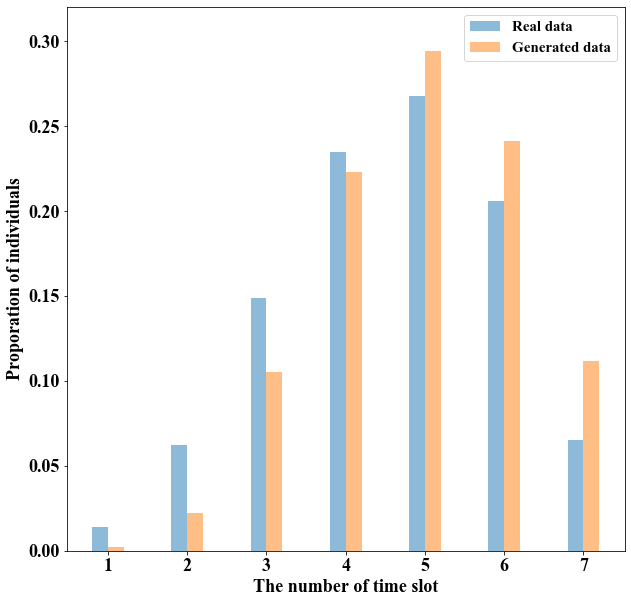

In [41]:
make_plot_sdzh(h_sd_dict['sd'],g_sd_dict['sd'])

### Distribution of entropy of trip destinations

In [42]:
def cal_entropy(in_df):
    veh_list = list(set(in_df.hphm))
    E_dict = {}
    num_list = []
    e_list = []
    for v in veh_list:
        sub_df = in_df.query(f"hphm == '{v}'")
        park_dict = dict(Counter(sub_df.tpark))
        park_list = [v for k,v in park_dict.items()]
        num_list.append(sum(park_list))
        park_array = np.asarray(park_list)
        park_array = park_array/sum(park_array)
        log_probs = np.log2(park_array)
        shang = -1*np.sum(park_array*log_probs)
        e_list.append(abs(round(shang,1)))
    E_dict['num'] = num_list
    E_dict['shang'] = e_list
    return E_dict

def shang_process_raw(indi_shang):
    "Calculation of entropy for commuter and other two types of traveler"
    raw_ar = np.zeros([50,50],dtype = int)
    for f,s in zip(indi_shang['num'],indi_shang['shang']):
        if  f <= 45 and s <5:
            fre = int(f)
            shang = 49-int(abs(s)*10)
            raw_ar[shang][[fre-1]]+=1
    out_ar = raw_ar/raw_ar.sum(axis = 0)
    out_ar[np.isnan(out_ar)] = 0
    return out_ar

def shang_process_gp(indi_shang):
    "Calculation of entropy for high-freq traveler"
    raw_ar = np.zeros([50,50],dtype = int)
    for f,s in zip(indi_shang['num'],indi_shang['shang']):
        if 41<= f <= 90 and 1< s <6:
            s-=1
            s = round(s,2)
            fre = int(f)
            shang = 49-int(abs(s)*10)
#             print(fre,shang)
            raw_ar[shang][[fre-41]]+=1
    out_ar = raw_ar/raw_ar.sum(axis = 0)
    out_ar[np.isnan(out_ar)] = 0
    return out_ar

In [43]:
shang_g = cal_entropy(trip_df_g)
shang_h = cal_entropy(trip_df_h)
out_ar_h = shang_process_gp(shang_h)
out_ar_g = shang_process_gp(shang_g)

c:\Users\LiGuilong\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


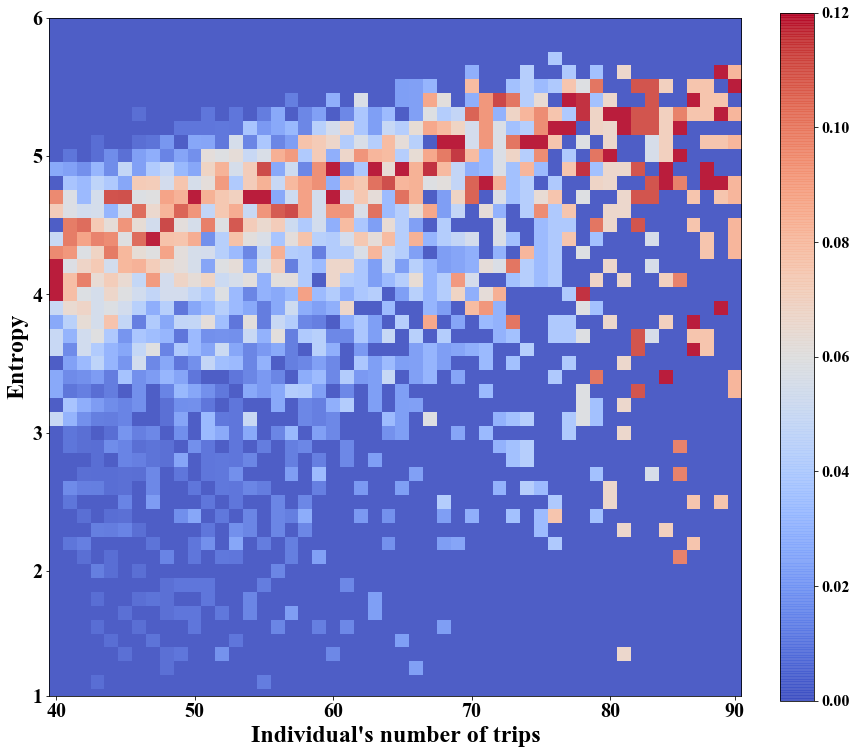

In [83]:
fig2,ax2 = plt.subplots(1,1,figsize=(12,12))                           # 设置画布大小
plt.imshow(out_ar_g, 
           cmap = 'coolwarm',              # 当设置为'auto
           alpha=0.9,
            # 当设置为lower时，热图的左下角为(0,0)
              # vmin和vmax参数用于限定数值的范围，只将vmin和vmax之间的值进行映射
           vmin=0, vmax=0.12)
ax_l = list(np.arange(50))
# plt.xticks([0,10,20,30,40,49],[1,10,20,30,40,50],fontproperties = 'Times New Roman',size = 20)
# plt.yticks([0,10,20,30,40,49],[5,4,3,2,1,0],fontproperties = 'Times New Roman',size = 20)

# plt.xticks([0,10,20,30,39],[1,10,20,30,40],fontproperties = 'Times New Roman',size = 20)
# plt.yticks([0,10,20,30,40],[5,4,3,2,1],fontproperties = 'Times New Roman',size = 20)

plt.xticks([0,10,20,30,40,49],[40,50,60,70,80,90],fontproperties = 'Times New Roman',size = 20)
plt.yticks([0,10,20,30,40,49],[6,5,4,3,2,1],fontproperties = 'Times New Roman',size = 20)


# ax2.axes.yaxis.set_ticks([])
# plt.xlim((-1,49))
cb = plt.colorbar(fraction=0.045,pad=0.05)
cb.ax.tick_params(labelsize=16)
plt.xlabel("Individual's number of trips",fontproperties = 'Times New Roman',size = 24)
plt.ylabel("Entropy",fontproperties = 'Times New Roman',size = 24)
# plt.legend(prop=  {'family':'Times New Roman','size':24})
plt.tight_layout()
# plt.savefig("./fig/shang_gp_g.pdf")
plt.show()